# Introducción

En este laboratorio, vamos a realizar tres actividades:


1.   En primer lugar, usando una Convolutional Neural Network (CNNs), vamos a realizar un clasificador de imágenes.
2.   En segundo lugar, vamos a jugar con Style Transfer y aplicaremos un determinado estilo (Pop Art, Picasso, Van Gogh, ...) a una imagen cualquiera.
3.  Por último, trabajaremos la detección de objetos dentro de una imagen



## Cargamos/Leemos imágenes

Antes de nada, vamos a cargar (y visualizar) imágenes en formato JPG, JPEG, etc...

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
# Función para convertir un tensor (TensorFlow) en una imagen
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# Función para leer una imagen dado un PATH para dicha imagen
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


In [ ]:
# Subimos cualquier imagen que queramos y obtenemos su directorio/PATH.

# Usa la función load_img para cargar esa imagen en una variable
load_img("/content/20220726_130413.jpg")


<tf.Tensor: shape=(1, 384, 512, 3), dtype=float32, numpy=
array([[[[0.882353  , 0.909804  , 0.9333334 ],
         [0.882353  , 0.909804  , 0.9333334 ],
         [0.89019614, 0.909804  , 0.929902  ],
         ...,
         [0.89019614, 0.9176471 , 0.9568628 ],
         [0.8862746 , 0.9215687 , 0.9568628 ],
         [0.8862746 , 0.91372555, 0.95294124]],

        [[0.87843144, 0.9058824 , 0.9294118 ],
         [0.882353  , 0.909804  , 0.9333334 ],
         [0.89019614, 0.9071079 , 0.93872553],
         ...,
         [0.8862746 , 0.91372555, 0.95294124],
         [0.8862746 , 0.91372555, 0.95294124],
         [0.8803003 , 0.9155944 , 0.9508885 ]],

        [[0.8862746 , 0.9058824 , 0.9294118 ],
         [0.8862746 , 0.9058824 , 0.9294118 ],
         [0.8862746 , 0.9046876 , 0.9318015 ],
         ...,
         [0.87843144, 0.91372555, 0.9490197 ],
         [0.87843144, 0.91372555, 0.9490197 ],
         [0.87843144, 0.91372555, 0.9490197 ]],

        ...,

        [[0.24232538, 0.2518076 , 

In [ ]:
# ¿Cuáles son las dimensiones de la imagen?
from PIL import Image
img = Image.open("/content/20220726_130413.jpg")
width, height = img.size
print('Ancho:', width)
print('Alto:', height)


Ancho: 4032
Alto: 3024


In [ ]:
# Usando tf.squeeze(), quedarnos únicamente con las capas que nos interesan y dejar la imagen en una matriz de 3 dimensiones
import tensorflow as tf

# Convertir la imagen a un tensor de 3 dimensiones
img_tensor = tf.keras.preprocessing.image.img_to_array(img)

# Quitar las dimensiones que tienen tamaño 1
img_tensor = tf.squeeze(img_tensor)

# Mostrar la forma resultante del tensor
print(img_tensor.shape)


(3024, 4032, 3)


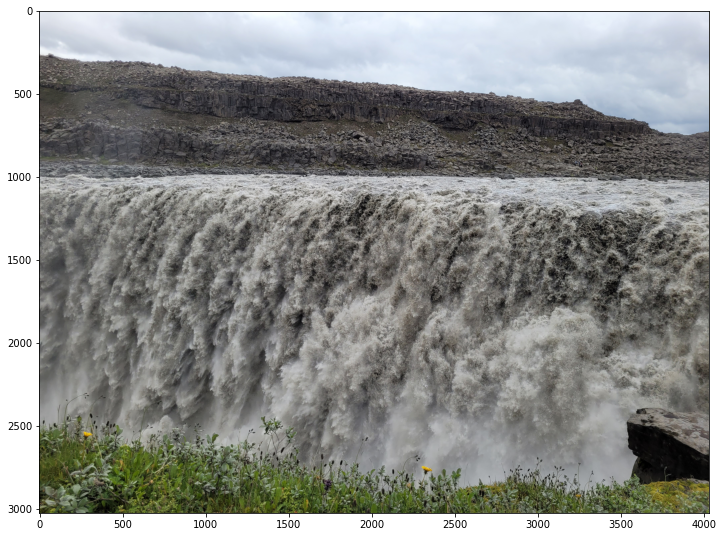

In [ ]:
# Mostramos la imagen por pantalla
plt.imshow(img)
plt.show()


## Clasificador de imágenes con CNNs

Para esta primera parte, vamos a hacer uso de una red preentrenada (VGG19). Esta red neuronal está disponible en Keras (TensorFlow). 

In [ ]:
# Cargar la red neuronal VGG19 haciendo uso de TensorFlow
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

model = VGG19(weights='imagenet', include_top=True)


574710816/574710816 [==============================] - 2s 0us/step


In [ ]:
# Una vez cargada la red neuronal, vamos a ver todas las capas de las que está formada. Para ello, imprime por pantalla de qué capas consta.
for layer in model.layers:
    print(layer.name)

# ¿Cómo difiere VGG19 en comparación con VGG16 (vista en clase)?
#es cargar el VGG16 pero como ya esta el VGG19 es lo mismo

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [ ]:
# ¿Cuántos parámetros tiene la red VGG19?
model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# ¿Cómo podemos ver los filtros que se utilizan (así como el tamaño de los mismos), por cada capa (incluyendo strides/Padding)?
!pip install prettytable

from prettytable import PrettyTable

table = PrettyTable(['Layer Name', 'Filter Size', 'Stride', 'Padding'])

for layer in model.layers:
    if 'conv' in layer.name:
        weights, biases = layer.get_weights()
        table.add_row([layer.name, weights.shape, layer.get_config()['strides'], layer.get_config()['padding']])

print(table)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+--------------+------------------+--------+---------+
|  Layer Name  |   Filter Size    | Stride | Padding |
+--------------+------------------+--------+---------+
| block1_conv1 |  (3, 3, 3, 64)   | (1, 1) |   same  |
| block1_conv2 |  (3, 3, 64, 64)  | (1, 1) |   same  |
| block2_conv1 | (3, 3, 64, 128)  | (1, 1) |   same  |
| block2_conv2 | (3, 3, 128, 128) | (1, 1) |   same  |
| block3_conv1 | (3, 3, 128, 256) | (1, 1) |   same  |
| block3_conv2 | (3, 3, 256, 256) | (1, 1) |   same  |
| block3_conv3 | (3, 3, 256, 256) | (1, 1) |   same  |
| block3_conv4 | (3, 3, 256, 256) | (1, 1) |   same  |
| block4_conv1 | (3, 3, 256, 512) | (1, 1) |   same  |
| block4_conv2 | (3, 3, 512, 512) | (1, 1) |   same  |
| block4_conv3 | (3, 3, 512, 512) | (1, 1) |   same  |
| block4_conv4 | (3, 3, 512, 512) | (1, 1) |   same  |
| block5_conv1 | (3, 3, 512, 512) | (1, 1) |   same  |
| block5_conv2 | (3, 

In [ ]:
# Vamos a preprocesar la entrada para que VGG19 puede hacer uso de ella, y vamos a reescalar la imagen acorde a la estructura de la red neuronal.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np

# Carga la imagen
img = image.load_img("/content/20220726_130413.jpg", target_size=(224, 224))

# Convierte la imagen a un arreglo de NumPy
x = image.img_to_array(img)

# Agrega una dimensión adicional para convertir la imagen en un lote de un solo elemento
x = np.expand_dims(x, axis=0)

# Preprocesa la imagen para que pueda ser utilizada por la red VGG19
x = preprocess_input(x)


In [ ]:
# Comprobamos que la imagen anterior tiene las dimensiones requeridas.
print(x.shape)

(1, 224, 224, 3)


In [6]:
# Aplica la red neuronal VGG a la imagen de entrada anterior.
prediction_probabilities= model(x)
prediction_probabilities.shape


# ¿Qué es lo que hemos obtenido?
#Lo que se ha obtenido es la predicción de la imagen cargada en cuanto a las probabilidades de pertenencia a cada una de las 1000 clases del dataset ImageNet. La variable preds es un array de 1000 elementos, cada uno representando la probabilidad de pertenencia a una clase distinta.


# ¿Cuántas clases hay?
#Hay mil clases



NameError: ignored

In [ ]:
# Por último, intenta predecir las top-5 clases (categorías) para la imagen de entrada.
# Obtenemos las 5 clases más probables
decoded_preds = decode_predictions(predictions, top=5)[0]

# Imprimimos las etiquetas y probabilidades de las top-5 clases
for index, label, prob in decoded_preds:
    print("{}: {:.2f}%".format(label, prob*100))



NameError: ignored

## Style Transfer




In [ ]:
# Carga el modelo 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2' de Tensorflow Hub



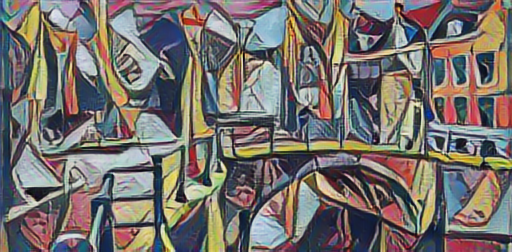

In [ ]:
# Aplica el Style Transfer entre dos imágenes y visualizalo con tensor_to_image


## Detección de objetos

Por último, trabajaremos la detección de objetos con redes ya preentrenadas.

In [ ]:
# Cargamos los modelos preexistentes de Tensorflow
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3699, done.
remote: Counting objects: 100% (3699/3699), done.
remote: Compressing objects: 100% (3089/3089), done.
remote: Total 3699 (delta 991), reused 1527 (delta 561), pack-reused 0
Receiving objects: 100% (3699/3699), 48.77 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (991/991), done.


In [ ]:
# Instalamos el repositorio anterior
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5.2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Ahora tenemos un paquete llamado object_detection que nos permite múltiples funcionalidades.
# Cargamos las más importantes
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

In [ ]:
# Cargamos los nombres de las etiquetas
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
# Carga el modelo de detección llamado 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1'




In [ ]:
# Elige to propia imagen: Ejemplo "/content/Amsterdam.jpeg"
path_image_object_detection = '/directorio/a/tu/imagen'

In [ ]:
# Lee la imagen y adapta la salida a uint8.
from PIL import Image, ImageDraw, ImageFont
from six import BytesIO

image_data = tf.io.gfile.GFile(path_image_object_detection, 'rb').read()
image = Image.open(BytesIO(image_data))

(im_width, im_height) = image.size
input_image = np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# Aplica el detector de objetos a la imagen input_image. 
# Llama a este resultado detector_output
# Explora el objeto resultante y quédate con "detection_classes" y guárdalo en una variable llamada class_ids



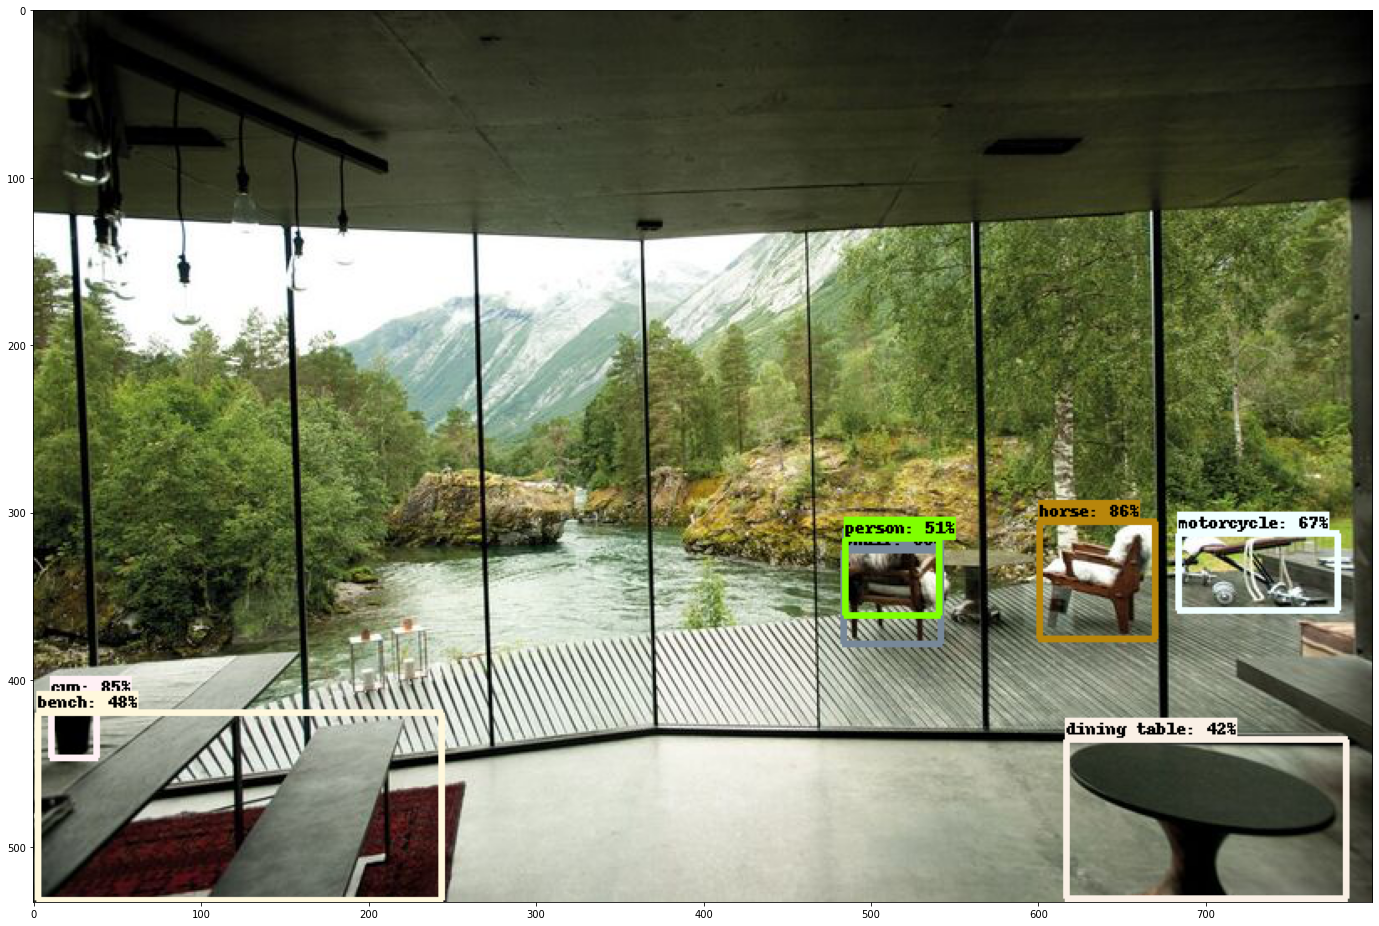

In [ ]:
label_id_offset = 0
image_np_with_detections = input_image.copy()
result = {key:value.numpy() for key,value in detector_output.items()}

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()